# 0. Вступление

В этом ноутбуке мы сделаем первую часть нашего приложения -- модель, которая детектирует строки текста на изображении. 

Следующие несколько ячеек будут общими для всех последующих ноутбуков.

* Эта ячейка настраивает отображение ipython widgets

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

* Подключаем Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

* Указываем путь к папке с кодом: 

In [ ]:
repo_folder = '/content/drive/MyDrive/DeepLearning2/'

* Устанавливаем зависимости

In [ ]:
reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

* Подключаем WandB

In [ ]:
import wandb
wandb_key = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
wandb.login(key=wandb_key.strip())

* Подключаем утилиты для этого ноутбука

In [ ]:
import sys
base_folder = repo_folder + 'IntelligentDocumentProcessing/Resources/a_Text_Detection/'
sys.path.append(base_folder)

## Фиксируем генераторы случайных чисел 

Почти всегда очень важна воспроизводимость эксперимента: сможем ли мы повторить результаты, которые получили в опыте. С другой стороны, в глубоком обучении очень многое зависит от значений, которые выдают генераторы случайных чисел. Поэтому очень важно убедиться в том, что генерируемые нами случайные значения будут одинаковы от запуска к запуску, если ничего не изменяется.

Для достижения воспроизводимости, нужно грамотно инициализировать все используемые генераторы случайных чисел. Это и происходит в следующей функции.

In [ ]:
from utils import set_seed

set_seed(17)

# 1. Данные

При разработке этого модуля, мы будем использовать данные из датасета [HierText](https://github.com/google-research-datasets/hiertext) от Google Research.

Данные разложены по папкам `train` и `validation`, разметка -- по файлам `train.jsonl` и `validation.jsonl`.

Наша задача на этом этапе -- считать и проанализировать данные из файлов, а затем сделать класс, который умеет возвращать изображение с разметкой по индексу изображения. 

Это достаточно простая инженерная задача, для которой требуется написать много кода. Этот код постоянно изменяется от задачи к задаче и конкретная реализация этого этапа важна только для определенной задачи. Поэтому мы предлагаем просто ознакомиться с нашей реализацией класса, который подгружает информацию из банка данных. Класс называется `HierTextAdapter` и имеет следующий интерфейс (описаны не все методы, а только ключевые):

```python
class HierTextAdapter(BaseAdapter): 
  '''
  В базовом адаптере реализован общий функционал, например, методы, 
  которые не меняются от датасета к датасету. 
  '''
  def load_anns(self):
    '''
    Метод загружает данные из разметки в формате JSON.
    '''
    pass
  
  def prepare_ann(ann):
    '''
    Метод приводит один элемент разметки к стандартизированному
    виду, чтобы разметку можно было подавать в модель или 
    функцию потерь и метрики. 
    '''
    pass
  
  def __getitem__(self, idx) -> Item:
    '''
    Метод возвращает всю информацию об одном элементе разметки: 
    название изображения, изображение и всю информацию об этом
    изображении из разметки. 
    '''
    pass
```

В общем случае такого рода классы пишутся следующим образом: берется одно изображение и соответствующая ему разметка из базы данных. Далее разметка преобразуется так, чтобы с ней можно было сравнить выход из модели. Очень важно визуализировать соответствие объекта и изображения. Если соответствия нет, то происходит поиск ошибок в преобразовании разметки до тех пор, пока она не будет соответствовать изображению. Если соответствие наблюдается уже на нескольких изображениях, то очень высока вероятность того, что все сделано правильно, и полученный код можно обернуть в класс или функцию (класс обычно лучше). 

Однако иногда бывают ситуации, когда некоторые изображения, например, неправильно ориентированы или хранятся в другом формате. Поэтому очень часто необходимо достаточно долго глазами отсматривать датасет на предмет неприятных ошибок и несоответствия разметки изображению, причем время, которое нужно на это потратить, заранее сложно прогнозировать. Очень часто бывает так, что в датасете присутствует несколько "битых" объектов, которые значительно портят модель в процессе обучения. Так что этот этап не стоит недооценивать.

Обычно процесс написания класса для считывания данных занимает от *нескольких часов* (в случае с хорошо документированными или структурированными данными) *до недели* (сложные, плохо документированные данные).

## 1.1. Загрузка данных

Загрузка может занять несколько минут, так как датасет достаточно большой. 

In [ ]:
%%time

from utils import HierTextAdapter

# HierText
train_hiertext_adapter = HierTextAdapter(
    ann_path='/content/drive/MyDrive/data/hiertext/train.jsonl',
    img_dir='/content/drive/MyDrive/data/hiertext/train',
    unclip_ratio=0,
    fit_min_rot_box=False,
    in_memory=False
)

train_adapters = [
    train_hiertext_adapter,
]
_ = [a[0] for a in train_adapters]

# HierText
val_hiertext_adapter = HierTextAdapter(
    ann_path='/content/drive/MyDrive/data/hiertext/validation.jsonl',
    img_dir='/content/drive/MyDrive/data/hiertext/validation',
    unclip_ratio=0,
    fit_min_rot_box=False,
    in_memory=False
)

val_adapters = [
    val_hiertext_adapter,
]
_ = [a[0] for a in val_adapters]

### 1.1.1. Визуализация

В процессе подготовки данных к обучению, очень важно визуализировать соответствие данных и входного сигнала. Для отображения мы реализовали класс `DrawMore`. Реализация такого класса -- это тоже инженерная задача, и код также может изменяться от случая к случаю, поэтому с конкретной реализацией в нашем случае можете ознакомиться в соответствующем файле `utils/drawmore.py`.

Для визуализации обычно используется библиотека `cv2`. Отображение обычно происходит при помощи `matplotlib`.

In [ ]:
import matplotlib.pyplot as plt
from utils import DrawMore

item = train_hiertext_adapter[6]

plt.figure(figsize=(15,20))
plt.imshow(DrawMore.draw_contours(item.img, item.word_polygons, thickness=1))
plt.show()

### 1.1.2. Подсчет статистик

Очень часто неприятная проблема может возникнуть, если не проверить, что все изображения можно считать и построить визуализацию, поэтому стоит хотя бы по разу считать каждое изображение. Это может занимать довольно продолжительное время, поэтому можно также посчитать какие-нибудь статистики в банке данных.

#### Задача 1. Статистика Bounding Box-ов

Задача состоит в том, чтобы посчитать статистику по длине/ширине изображений в адаптере `val_hiertext_adapter`. У нас есть вспомогательный файл, который пригодится для этой и следующей задачи. Это список длиной с валидационную выборку, где для каждого изображения сохранены координаты всех полигонов и размерности изображения. Давайте его сначала загрузим и посмотрим на него:

In [ ]:
import json

with open(base_folder + 'resources/bboxes_and_shapes_by_image.json', 'r') as r:
  bboxes_and_shapes_by_image = json.load(r)

assert len(bboxes_and_shapes_by_image) == len(val_hiertext_adapter)
print(f'Количество слов на первом изображении: {len(bboxes_and_shapes_by_image[0][0])}')
print(f'Первый bounding box на первом изображении: {bboxes_and_shapes_by_image[0][0][0]}')
print(f'Размер первого изображения: {bboxes_and_shapes_by_image[0][1]}')

Ваша задача: собрать в переменные `widths` и `heights` ширину и высоту для каждого ббокса (должны быть два списка типа `float`). Есть один нюанс: полигоны, которые будет возвращать адаптер, не параллельны осям координат (другими словами, это повернутые прямоугольники). Поэтому высоту/ширину вычислять будет не так просто, но можно воспользоваться, например, методом `cv2.minAreaRect`. 

##### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
widths = ...
heights = ...

In [ ]:
# РЕШЕНИЕ (пример)
import cv2

all_bboxes = [bbox 
              for word_polygons, _ in bboxes_and_shapes_by_image 
              for bbox in word_polygons]

widths = []
heights = []
for bbox in all_bboxes:
    (_, _), (w, h), _ = cv2.minAreaRect(np.array(bbox))
    widths.append(w)
    heights.append(h)

#### Проверка

In [ ]:
all_polygons_len = len([bbox 
                        for one_image_bboxes, _ in bboxes_and_shapes_by_image 
                        for bbox in one_image_bboxes])
assert len(widths) == all_polygons_len, 'Длина списка widths не равняется общему количеству боксов.'
assert len(heights) == all_polygons_len, 'Длина списка heights не равняется общему количеству боксов.'

assert hash(tuple(sorted(widths))) == 187338010177957256, 'Список widths построен некорректно.'
assert hash(tuple(sorted(heights))) == -5793582464695214423, 'Список heights построен некорректно.'

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(widths, bins=70, alpha=0.5)
plt.hist(heights, bins=70, alpha=0.5)
plt.show()

Обратите внимание на распределение по высоте/ширине. Можно ли сказать, что размеры боксов имеют большое разнообразие? Как можно решить проблему в том случае, если все боксы более-менее одинакового размера на всем датасете, а в реальной жизни они могут быть совершенно разных размеров? 


#### Задача 2 (опциональная). Heatmap слов на изображениях

Мы выяснили, какие размеры имеют боксы в нашем датасете. Но также неплохо было бы понять, где они находятся на изображениях. Вдруг они все в центре картинки? 

Ваша задача: необходимо на маске размером $500 \times 500$ пикселей отобразить тепловую карту для всех bounding box-ов на всех изображениях. 

Каждый пиксель целевой маски будет иметь значения от 0 до 1 и показывать, на каком проценте изображений тот или иной пиксель был в пределах bbox-а для слова. Например, если пиксель в точке (10, 10) был в пределах какого-то слова на 10 изображениях из 100, то значение этого пикселя будет 0.1. 

Для этого мы можем переиспользовать переменную `bboxes_and_shapes_by_image` из предыдущего задания и достать из нее полигоны и размеры картинок, так как все bbox-ы нам необходимо будет перевести из размера исходной картинки в размер $500 \times 500$.  

Также после каждой нормировки необходимо округлять значения bbox-ов с помощью `np.round`. 

##### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
from typing import List, Tuple
import numpy as np

def make_heatmap(
    bboxes_and_shapes_by_image: List[Tuple[List[np.ndarray], List[Tuple]]],
    adapter: HierTextAdapter, 
    res_w: int = 500, 
    res_h: int = 500
) -> np.ndarray:
    pass

#### Проверка

In [ ]:
heatmap = make_heatmap(bboxes_and_shapes_by_image, 500, 500)

plt.figure(figsize=(8, 8))
plt.imshow(heatmap)
plt.colorbar()
plt.show()

In [ ]:
assert heatmap.shape == (500, 500), 'Размер тепловой карты должен быть равен 500 x 500.'

# сравним с правильной тепловой картой
true_heatmap = np.load(base_folder+'resources/true_heatmap.npy')
diff = np.sum(np.abs(true_heatmap - heatmap))
msg = f'Ваша тепловая карта не сходится с истинной. Разница: {diff}'
assert np.allclose(true_heatmap, heatmap, atol=1e-4), msg

Из этих двух задач мы можем сделать один важный вывод - bounding box-ы у нас в основном небольшие и их нет по краям. Обе эти проблемы можно решить несколькими способами: 
* Использовать не оригинальные изображение, а вырезать случайные участки изображений;
* Приближать и отдалять изображения;
* Какие еще способы? 

## 1.2. Аугментации и подготовка DataLoader

### 1.2.1. Аугментации

Для улучшения устойчивости модели к небольшим изменениям, используем аугментации.

Аугментации традиционно делятся на три части:

1. Предобработка
2. Собственно аугментации
3. Постобработка

Сначала определим предобработку, а потом перейдем к содержательным аугментациям. 

В предобработке мы будем приводить все изображения к фиксированному размеру $2048 \times 2048$ с сохранением соотношений сторон. Для этого самую большую сторону изображения мы будем приводить к размеру $2048$, а затем добавлять другое измерение надставлять нулями до $2048$ пикселей.

In [ ]:
import albumentations as A

size = 512
size_transform = A.Compose([
    A.LongestMaxSize(
        max_size=size,
        p=1.0,
    ),
    A.PadIfNeeded(
        min_height=size,
        min_width=size,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=None,
        always_apply=False,
        p=1.0,
    ),
])

#### Задача 3. Подбор аугментаций

Эта задача будет поделена на 4 небольшие части:
1. Аугментации с изменением цветов
2. Аугментации с шумом
3. Аугментации с перспективными изменениями
4. Сборка всех аугментаций. 

Каждую аугментацию можно предварительно посмотреть в [демо от albumentations](https://albumentations-demo.herokuapp.com/). 

Обратите внимание, что каждая группа преобразований будет внутри контейнера `A.OneOf`. Это значит, что при каждом его вызове будет случайным образом выбираться одна из аугментаций, прописанных внутри. Поэтому для каждой необходимо прописывать параметр `p`, от которого зависит вероятность выбора той или иной аугментации. Все параметры `p` внутри `A.OneOf` нормируются, поэтому они не должны в сумме давать 1 или быть от 0 до 1, то есть это больше не вероятности, а веса. 

Все аугментации будет тестировать на этом примере: 

In [ ]:
image = cv2.imread(base_folder+'examples/example_itw.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

##### 3.1 Аугментации с изменением цветов

Часто бывает, что какой-то домен имеет определенные свойства изображений - например, в документах почти всегда черный текст на белом фоне. Но в задаче scene text detection это не так - изображения могут быть любого цвета и шрифты могут быть очень разными. Чтобы эмулировать это в процессе обучения мы будем использовать преобразования, которые так или иначе изменяют цвета на исходном изображении: `RandomBrightnessContrast`, `RGBShift`, и `ChannelShuffle`. 

Также выбирайте параметры такие, чтобы текст не пропадал с изображения и чтобы он был читабельным, иначе модель не сможет обобщиться на данных, на которых нет текста. 

In [ ]:
NROWS = 3
NCOLS = 6
FIGSIZE = (24, 12)

###### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
color_transforms = A.OneOf([
    A.RandomBrightnessContrast(...),
    A.RGBShift(...),
    A.ChannelShuffle(...),
])

###### Проверка

In [ ]:
fig, axs = plt.subplots(NROWS, NCOLS, figsize=FIGSIZE)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
for i in range(1, 18):
  col = i % NCOLS
  row = i // NCOLS
  image_transformed = color_transforms(image=image)['image']
  axs[row, col].imshow(image_transformed)
  axs[row, col].set_title(f'Transformed {i}')
plt.show()

##### 3.2 Аугментации с шумом

Также в арсенале аугментаций обязательно должны быть различные шумы. Опять-таки на примере документов - фоны там обычно идеально ровные и монотонные, чего в реальной жизни (in the wild) почти не бывает. Поэтому мы добавляем шумы типа `GaussNoise` и `ISONoise`. Исходя из названий, как вы думаете, чем отличаются эти шумы? 

Опять же, перебарщивать не стоит, так как излишнее зашумление может только помешать. 

###### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
noise_transforms = A.OneOf([
    A.GaussNoise(...),
    A.ISONoise(...)
])

###### Проверка

In [ ]:
fig, axs = plt.subplots(NROWS, NCOLS, figsize=FIGSIZE)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
for i in range(1, 18):
  col = i % NCOLS
  row = i // NCOLS
  image_transformed = noise_transforms(image=image)['image']
  axs[row, col].imshow(image_transformed)
  axs[row, col].set_title(f'Transformed {i}')
plt.show()

##### 3.3 Аугментации с перспективными изменениями

Это, наверное, самый интересный набор аугментаций. Мы уже видели на тепловой карте bounding box'ов то, что текст по краям изображения встречается реже, чем в центре, а также мы сами, посмотрев на улицу, можем заметить разнообразие форм и размеров текстов, которые нас окружают. Для того, чтобы это симулировать, предлагаем использовать аугментации `RandomRotate90` (поворот на угол, кратный 90 градусам), `ShiftScaleRotate` (сдвиг, изменение масштаба и поворот на произвольынй угол) и `Perspective` (четыре точки угла изображения случайным образом перемещаются, создавае перспективное искажение). 

Важно в этих аугментациях соблюдать осторожность при выборе параметров. Например, если задавать большой `shift` в `ShiftScaleRotate`, то весь текст с изображения может пропасть. Также в этом преобразовании нет смысла указывать углы больше 45 градусов, поскольку совместно с `RandomRotate90` уже покрываются все возможные 360 градусов (здесь в качестве контейнера выступает не `OneOf`, а `Compose`, в котором аугментации вызываются последовательно, каждая с вероятностью `p`). 

###### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
geometric_transforms = A.Compose([
    A.RandomRotate90(...),
    A.ShiftScaleRotate(...),
    A.Perspective(...),
])

###### Проверка

In [ ]:
fig, axs = plt.subplots(NROWS, NCOLS, figsize=FIGSIZE)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
for i in range(1, 18):
  col = i % NCOLS
  row = i // NCOLS
  image_transformed = geometric_transforms(image=image)['image']
  axs[row, col].imshow(image_transformed)
  axs[row, col].set_title(f'Transformed {i}')
plt.show()

##### 3.4 Сборка всех аугментаций

Остается собрать воедино все преобразования, которые вы объявили выше: 

###### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
train_transform = A.Compose([
    size_transform,
    
    A.OneOf([
        # изменения цветов
    ], p=...),
    A.InvertImg(p=0.1),
    A.HueSaturationValue(p=0.2, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
    A.OneOf([
        # шум
    ], p=...),
    A.OneOf([
        # перспективные изменения
    ], p=...),
    A.ToGray(p=0.3),
])

Далее мы загружаем 2 картинки - оригинальную и уже с готовыми аугментациямиями (референс). Запустите ячейку с отрисовкой этих изображений и сравните свои аугментации с референсом. Можете запустить ячейку с отрисовкой несколько раз, чтобы посмотреть на различные комбинации аугментаций. 

###### Проверка

In [ ]:
image = cv2.imread(base_folder+'examples/example_itw.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_auged_ref = cv2.imread(base_folder+'examples/example_itw_auged.jpeg')
image_auged_ref = cv2.cvtColor(image_auged_ref, cv2.COLOR_BGR2RGB)

In [ ]:
fig, axs = plt.subplots(NROWS, NCOLS, figsize=FIGSIZE)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(image_auged_ref)
axs[0, 1].set_title('Reference')
for i in range(2, 18):
  col = i % NCOLS
  row = i // NCOLS
  # здесь используем train_transform[1:] для того, чтобы все картинки остались одного размера
  image_transformed = A.Compose(train_transform[1:])(image=image)['image']
  axs[row, col].imshow(image_transformed)
  axs[row, col].set_title(f'Transformed {i-1}')
plt.show()

Наконец, перейдем к постпроцессингу. Постпроцессинг обычно заключается в нормализации изображения и приведения к тензорному виду. Для этого есть два класса:

* `albumentations.Normalize`
* `albumentations.pytorch.ToTensorV2`

In [ ]:
from albumentations.pytorch import ToTensorV2

val_transform = size_transform
test_transform = size_transform

post_transform = A.Compose([
    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])

### 1.2.2. Визуализация аугментаций

Очень важно визуализировать аугментации на данных. Мы уже написали простой кусочек кода, который помогает понять, как аугментации работают.

In [ ]:
from utils import DBDataset

dataset = DBDataset(train_adapters, train_transform, post_transform)
idx = np.random.choice(len(dataset))
raw_image, image, shrink_map, shrink_mask, threshold_map, threshold_mask, gt_polygon = dataset[idx]

fig, ax = plt.subplots(1, 5, figsize=(20, 20), dpi=200)

ax = ax.ravel()

ax[0].set_title('image')
ax[0].imshow(raw_image)

ax[1].set_title('shrink_map')
ax[1].imshow(shrink_map)

ax[2].set_title('shrink_mask')
ax[2].imshow(shrink_mask)

ax[3].set_title('threshold_map')
ax[3].imshow(threshold_map)

ax[4].set_title('threshold_mask')
ax[4].imshow(threshold_mask)


plt.show()

### 1.2.3. Преобразование сегментации в bounding box-ы

Мы решаем задачу при помощи сегментации, поэтому результатом решения будут сегментационные карты. Для того, чтобы превратить карты сегментации в bounding box-ы, необходимо использовать постпроцессинг, который уже реализован. 

Идея этой постобработки заключается в том, что она будет проходить по каждому контуру из предсказанной маски и превращать его в bounding box из четырех точек с помощью все того же метода `cv2.minAreaRect`.

In [ ]:
from utils import Postprocessor

postprocessor = Postprocessor(
    unclip_ratio=1.5,
    binarization_threshold=0.3,
    confidence_threshold=0.7,
    min_area=1,
    max_number=1000
)

In [ ]:
idx = np.random.choice(len(dataset))
raw_image, image, shrink_map, shrink_mask, threshold_map, threshold_mask, gt_polygon = dataset[idx]
h, w, c = raw_image.shape
shrink_map= np.expand_dims(np.expand_dims(shrink_map, axis=0), axis=0)
map_polygons, _ = postprocessor(w, h, shrink_map, return_polygon=False)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

ax = ax.ravel()

ax[0].set_title('image')
ax[0].imshow(raw_image)

ax[1].set_title('segmentation')
ax[1].imshow(shrink_map[0][0])

ax[2].set_title('bounding boxes')
ax[2].imshow(DrawMore.draw_contours(np.zeros_like(raw_image), map_polygons[0], thickness=2))

plt.show()

### 1.2.4. Подготовка DataLoader-ов

Мы посмотрели на данные, подготовили аугментации - далее осталось только инициализировать датасеты (и даталоадеры) и можно переходить к метрикам и моделированию нейросети. 

In [ ]:
import os

from torch.utils.data import DataLoader

from utils import collate, worker_init_fn

num_workers = os.cpu_count()  # количество ядер CPU, которые мы выделяем даталоадеру
batch_size = 16  # количество изображений в одном батче

train_ds = DBDataset(
    adapters=train_adapters,
    transforms=train_transform,
    post_transforms=post_transform,
    size=1000  # на каждой эпохе для обучения будет 1000 изображений

)
val_ds = DBDataset(
    adapters=val_adapters,
    transforms=val_transform,
    post_transforms=post_transform,
    size=400  # на каждой эпохе для валидации будет 400 изображений
)

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=True,
    drop_last=False
)

val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=False,
    drop_last=False
)

# 2. Модель

Мы подготовили данные, теперь нужно сделать модель, которая на вход будет принимать изображение, а на выходе -- выдавать карты сегментации с областями, где найден текст.

В качестве модели мы будем использовать модель DB ([статья](https://arxiv.org/abs/1911.08947)), у которой есть условные "тело" (или "кодировщик") и "голова" (или "декодировщик"). На изображении ниже левая половина (до слоя CONCAT) - это "тело", которое мы возьмем готовое, а "голову" мы предлагаем ниже частично реализовать.


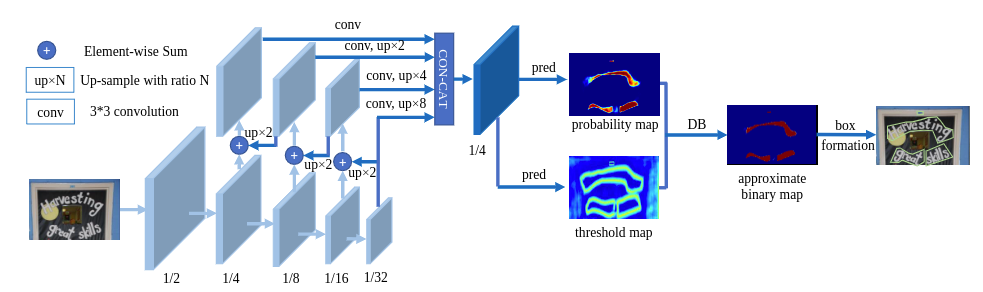

Вообще говоря, это хорошая практика -- брать хорошо изученные предобученные кодировщики. Этот подход называется transfer learning и позволяет получать более высокое качество, чем обучение с нуля. Это позволяет сэкономить время обучения и объем необходимой разметки. Причем стоит отметить, что это не зависит от задачи. Например, если вы сегментируете медицинские изображения, то кодировщики, предобученные на задаче классификации (ImageNet) все равно подходят и значитально улучшают качество результата.

Вернемся к нашей модели. В отличие от обычных сегментационных нейросетей, DB кроме вероятностей (probability map) предсказывает еще и уточненные границы слов (threshold map). Это позволяет превращать вероятностные маски в бинаризованные изображения с помощью step function - функции, которая из probability map и threshold map составляет бинарную маску. 

В реализации модели DB мы пойдем с конца (с самого интересного): реализуем step function, затем голову DB (класс `DBHead`), а в конце соберем всю модель в классе `DB`. 

### Задача 4. Step function для модели DB

Необходимо реализовать функцию, которая сможет обрабатывать сигналы, которые выходят из модели и получать из них регионы с текстом. Для этого в этой задаче мы реализуем функцию, которая превращает probability map и threshold map в регионы с текстом -- Step Function.

Формула для Step Function (из статьи) имеет следующий вид:

$$\hat{B}_{i, j} = \frac{1}{1+e^{-k(P_{i,j}-T_{i,j})}}$$

Где $\hat{B}_{i, j}$ - это динамически бинаризованное предсказание, $P_{i,j}$ - это probability map, $T_{i,j}$ - это threshold map, а $k$ - это коэффициент, который в статье равен 50. 

Необходимо реализовать данную функцию при данных `p`, `t` и `k`. 

In [ ]:
import torch

# КОД ДЛЯ СТУДЕНТА
def step_function(p: torch.Tensor, t: torch.Tensor, k: int = 50) -> torch.Tensor:
    pass

#### Проверка задачи 4

In [ ]:
# проверка функции, проверка изображения будет ниже
msg = 'Что-то не так с функцией step_function...'

p = torch.linspace(1, 100, 100)
t = torch.linspace(1, 100, 100)
k = 50
sf = step_function(p, t, k)
assert hash(tuple(sf.flatten().tolist())) == 4860710189162347763, msg

assert step_function(torch.tensor(0), torch.tensor(0), torch.tensor(0)).item() == 0.5, msg
assert round(step_function(torch.tensor(2), torch.tensor(1), torch.tensor(1)).item(), 4) == 0.7311, msg
assert round(step_function(torch.tensor(2), torch.tensor(1), torch.tensor(4)).item(), 4) == 0.982, msg
assert step_function(torch.tensor(2), torch.tensor(1), torch.tensor(20)).item() == 1.0, msg

Также проверим функцию `step_function` на реальных probability map и threshold map, которые мы извлечем из изображений, а также сравним их с правильным значением функции `step_function`, которое мы также извлечем из изображения: 

In [ ]:
prob_map = cv2.imread(base_folder + 'examples/prob_map.png', cv2.IMREAD_GRAYSCALE)
threshold_map = cv2.imread(base_folder + 'examples/threshold_map.png', cv2.IMREAD_GRAYSCALE)
true_after_step_function = cv2.imread(base_folder + 'examples/step_function.png', cv2.IMREAD_GRAYSCALE)

after_step_function = step_function(torch.from_numpy(prob_map/255), torch.from_numpy(threshold_map/255), k=50).numpy() * 255
assert np.allclose(true_after_step_function, after_step_function.astype(int)), msg

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.imshow(prob_map, cmap='gray')
ax1.set_title('probability_map')

ax2.imshow(threshold_map, cmap='gray')
ax2.set_title('threshold_map')

ax3.imshow(true_after_step_function, cmap='gray')
ax3.set_title('true after step_function')

ax4.imshow(after_step_function, cmap='gray')
ax4.set_title('after step_function')

plt.show()

Кроме этого, предлагаем посмотреть на значение `step_function` в зависимости от параметра $k$, особенно от 1 до 10 (запустите следующую ячейку и покрутите слайдер, при прокрутке слайдера картинка может обновляться примерно 0,5-1 секунду):

In [ ]:
from ipywidgets import interact, IntSlider

def wrapper(k=50):
  plt.figure(figsize=(6, 6))
  plt.imshow(step_function(torch.from_numpy(prob_map/255), torch.from_numpy(threshold_map/255), k), cmap='gray')
    
interact(wrapper, k=IntSlider(min=1, max=50, step=1, value=10));

### Задача 5: Реализация `DBHead`

В вашем распоряжении почти готовый класс, в котором осталось сделать несколько вещей:
1. Вставить реализацию метода `step_function` из предыдущей задачи (не забываем про `self`);
2. Реализовать метод `_init`, который инициализирует сразу две "головы" модели DB. Метод должен возвращать контейнер `nn.Sequential` со следующими слоями: 

- `Conv2d(inner_channels, inner_channels/4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)`
- `BatchNorm2d(inner_channels/4)`
- `ReLU`
- `ConvTranspose2d(inner_channels/4, inner_channels/4, kernel_size=(2, 2), stride=(2, 2), bias=False)`
- `BatchNorm2d(inner_channels/4)`
- `ReLU`
- `ConvTranspose2d(inner_channels/4, 1, kernel_size=(2, 2), stride=(2, 2))`
- `Sigmoid`




##### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА

from torch import nn

class DBHead(nn.Module):
    def __init__(self, in_channels: int, k: int = 50):
        """
        Класс головы модели DB из статьи https://arxiv.org/abs/1911.08947.

        Args:
            in_channels: входное количество каналов
            k: значение параметра k в step function (см. статью)
        """
        super().__init__()
        self.k = k
        self.binarize = self._init(in_channels)
        self.thresh = self._init(in_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shrink_maps = self.binarize(x)
        threshold_maps = self.thresh(x)
        binary_maps = self.step_function(shrink_maps, threshold_maps, self.k)
        y = torch.cat((shrink_maps, threshold_maps, binary_maps), dim=1)
        return y

    def _init(
        self,
        inner_channels: int,
    ) -> nn.Module:
        pass
    
    def step_function(self, p: torch.Tensor, t: torch.Tensor, k: int = 50) -> torch.Tensor:
        pass

##### Проверка задачи 5

In [ ]:
dbhead = DBHead(16, 50)

assert str(dbhead.thresh) == str(dbhead.binarize), 'Модули dbhead.thresh и dbhead.binarize должны быть идентичны.'
true_seq_str = '''Sequential(
  (0): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ConvTranspose2d(4, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(4, 1, kernel_size=(2, 2), stride=(2, 2))
  (7): Sigmoid()
)'''
assert str(dbhead.thresh) == true_seq_str, 'Модуль dbhead.thresh имеет неправильную архитектуру.'
assert dbhead(torch.rand(1, 16, 32, 32)).shape == torch.Size([1, 3, 128, 128]), 'Неправильная размерность на выходе из модели.'

### Задача 6. Сборка модели

Класс "головы" (декодировщик) для DBNet у нас уже реализован, поэтому нужно собрать "тело" (или кодировщик) и совместить с "головой". По шагам: 

1. В качестве кодировщика мы предлагаем взять `FPN` ([статья](https://arxiv.org/abs/1612.03144)) из библиотеки `segmentation-models-pytorch` с бэкбоном  `timm-regnetx_016` ([статья](https://arxiv.org/abs/2003.13678)), который необходимо передать как парамтр `encoder_name`. Кроме этого, в `FPN` есть своя сегментационная голова `segmentation_head`, которая нам не нужна, поэтому ее можно превратить в `torch.nn.Identity()`. 
2. В качестве декодировщика берем только что написанный класс `DBHead`, в который необходимо передать 2 параметра: `k` (рекомендуем поставить 50) и `in_channels`. Значение последнего мы вам не скажем, так как предоставляем это вам - вычислить количество выходных каналов из кодировщика, которые, в свою очередь, будут входными каналами в декодировщик. 


#### Код

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn.functional as F

# КОД ДЛЯ СТУДЕНТА
class DB(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = ...  # FPN из smp
        self.head = ...  # DBHead 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, _, H, W = x.size()
        x = self.body(x)
        x = self.head(x)
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        return x

#### Проверка задачи 6

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn

db = DB()

assert isinstance(db.body, smp.FPN), 'Кодировщик имеет неправильный класс, должен быть smp.FPN.'
assert isinstance(db.head, DBHead), 'Декодировщик имеет неправильный класс, должен быть DBHead.'

for module in db.modules():
    if hasattr(module, 'weight'):
        module.weight = nn.Parameter(torch.ones_like(module.weight))
    if hasattr(module, 'bias') and module.bias is not None:
        module.bias = nn.Parameter(torch.ones_like(module.bias))
inp = torch.ones(1, 3, 64, 64)
with torch.no_grad():
    out = db(inp)

head_msg = 'Что-то не так с возвращаемым значением головы db.head.{}. Точно с "головой" модели все в порядке?'
assert torch.allclose(out[0][0][0], torch.tensor([0.7311]*64), atol=1e-4), head_msg.format('binarize')
assert torch.allclose(out[0][1][0], torch.tensor([0.7311]*64), atol=1e-4), head_msg.format('threshold')
step_function_msg = 'Что-то не так с возвращаемым значением step_function. Точно step_function правильная? '
assert torch.allclose(out[0][2][0], torch.tensor([0.5]*64), atol=1e-4), step_function_msg

# 3. Метрики и функция потерь

Мы подготовили датасет и модель. И даже сделали функцию, которая интерпретирует выход из модели. Осталось только понять, как сравнивать предсказания модели и целевые значения (ground truth) -- и можно начинать обучение!

Для этого нужно определиться с функцией потерь и метрикой.

В качестве функции потерь мы будем использовать комбинацию нескольких функций, про которые мы поговорили в инструктаже: 
* `BalanceCrossEntropyLoss`
* `MaskL1Loss`
* `DiceLoss`

Они все уже реализованы, крайне рекомендуем посмотреть их реализацию в файле `IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/losses.py`. 

В качестве метрик возьмем метрики `Precision`, `Recall` и `F-Score`, которые будем рассчитывать по `IoU`. Например, при `IoU=0.05` мы будем считать метрики `Precision` и другие только для тех пар полигонов (предсказанный-целевой), у которых `IoU` выше значения 0.05. 

### Задача 7. Метрики

Вам предоставлен класс, подсчитывающий метрики. Все методы, кроме одного, реализованы. Необходимо реализовать метод `get_iou`, подсчитывающий intersection over union для двух заданных полигонов. 

(Подсказка: в [Shapely](https://shapely.readthedocs.io/en/stable/manual.html#polygons) есть все необходимые методы). 

#### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
from utils import BaseEvaluator
from shapely.geometry import Polygon

class Evaluator(BaseEvaluator):
    @staticmethod
    def get_iou(p1: Polygon, p2: Polygon) -> float:
        pass

#### Проверка

In [ ]:
evaluator = Evaluator()

# два квадрата, один в 4 раза больше другого
p1 = Polygon([[0, 0], [0, 100], [100, 100], [100, 0]])
p2 = Polygon([[0, 0], [0, 50], [50, 50], [50, 0]])
assert round(evaluator.get_iou(p1, p2), 5) == 0.25, 'Что-то не так с evaluator, ведь один квадрат в 4 раза больше другого... '

# два треугольника
p1 = Polygon([[100, 100], [200, 200], [300, 100]])
p2 = Polygon([[150, 150], [250, 250], [350, 150]])
assert round(evaluator.get_iou(p1, p2), 5) == 0.14286, 'Что-то не так с evaluator...'

# 4. Обучение

## 4.1. Pytorch Lightning Module

Мы будем использовать pytorch lightning для обучения. Для этого сначала нужно сделать pytorch lightning класс, в котором необходимо описать:

* \_\_init\_\_ - с определением модели, функций потерь, метрик и постобработки;
* training_step - с шагом обучения, подсчетом и логированием метрик
* validation_step - с шагом валидации, подсчетом и логированием метрик
* test_step - с шагом тестирования, подсчетом и логированием метрик (в нашем случае он будет аналогичным `validation_step`)
* configure_optimizers - с определением optimizer'а и scheduler'а. 

Всех тем, кроме оптимизации, мы ранее уже коснулись. В качестве `optimizer` мы рекомендуем использовать `AdamW` ([статья](https://arxiv.org/pdf/1711.05101.pdf)) и `CyclicLR` ([статья](https://arxiv.org/pdf/1506.01186.pdf)) в качестве `scheduler`. Они хорошо зарекомендовали себя в наших многочисленных экспериментах, но в домашнем задании вы при желании можете использовать любые другие алгоритмы оптимизации. 


In [ ]:
import pytorch_lightning as pl

from typing import Any, Tuple, List
from utils import DBLoss
from utils import log_losses_and_metrics, log_images

from torch import optim

class DBRunner(pl.LightningModule):
    def __init__(self):
        """
        Основной класс для обучения модели DB.
        """
        super(DBRunner, self).__init__()

        self.model = DB()

        self.evaluator = Evaluator()
        self.postprocessor = Postprocessor(
            unclip_ratio=1.5,
            binarization_threshold=0.3,
            confidence_threshold=0.7,
            min_area=1,
            max_number=1000
        )

        self.loss = DBLoss(
            alpha=1,
            beta=10,
            ohem_ratio=3,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Метод с имплементацией шага обучения.

        Args:
            batch: батч
            batch_idx: индекс батча

        Returns:
            лосс
        """
        raw_images, images, shrink_maps, shrink_masks, threshold_maps, threshold_masks, gt_polygons = batch
        current_batch_size = len(raw_images)
        preds = self.forward(images)

        losses = self.loss(preds, {
            'shrink_map': shrink_maps,
            'shrink_mask': shrink_masks,
            'threshold_map': threshold_maps,
            'threshold_mask': threshold_masks,
        })

        log_losses_and_metrics(self.log, losses, metrics=None, current_batch_size=current_batch_size, mode='train')

        log_images_every_n_epoch = 5

        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == 0:
            h, w, c = raw_images[0].shape

            shrink_maps = DrawMore.to_numpy(shrink_maps, unsqueeze=True)
            threshold_maps = DrawMore.to_numpy(threshold_maps, unsqueeze=True)
            pred_shrink_maps = DrawMore.to_numpy(preds[:, [0], :, :])
            pred_threshold_maps = DrawMore.to_numpy(preds[:, [1], :, :])
            pred_bin_maps = DrawMore.to_numpy(preds[:, [2], :, :])

            train_gt_polygons, _ = self.postprocessor(w, h, shrink_maps, return_polygon=False)
            train_polygons_after_step, _ = self.postprocessor(w, h, pred_bin_maps, return_polygon=False)
            metrics_after_step = self.evaluator(train_gt_polygons, train_polygons_after_step)

            log_images(
                self.trainer.logger,
                raw_images,
                shrink_maps,
                threshold_maps,
                pred_bin_maps,
                pred_shrink_maps,
                pred_threshold_maps,
                train_gt_polygons,
                train_polygons_after_step,
                metrics_after_step,
                mode='train',
                log_max=4
            )

        return losses["loss"]

    def validation_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Метод с имплементацией шага валидации.

        Args:
            batch: батч
            batch_idx: индекс батча
        """
        raw_images, images, shrink_maps, shrink_masks, threshold_maps, threshold_masks, gt_polygons = batch
        current_batch_size = len(raw_images)
        preds = self.forward(images)

        losses = self.loss(preds, {
            'shrink_map': shrink_maps,
            'shrink_mask': shrink_masks,
            'threshold_map': threshold_maps,
            'threshold_mask': threshold_masks,
        })

        h, w, c = raw_images[0].shape

        shrink_maps = DrawMore.to_numpy(shrink_maps, unsqueeze=True)
        pred_bin_maps = DrawMore.to_numpy(preds[:, [2], :, :])

        val_gt_polygons, _ = self.postprocessor(w, h, shrink_maps, return_polygon=False)
        val_polygons_after_step, _ = self.postprocessor(w, h, pred_bin_maps, return_polygon=False)
        metrics_after_step = self.evaluator(val_gt_polygons, val_polygons_after_step)

        log_losses_and_metrics(self.log, losses, metrics_after_step, current_batch_size=current_batch_size, mode='val')

        log_images_every_n_epoch = 5

        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == 0:
            threshold_maps = DrawMore.to_numpy(threshold_maps, unsqueeze=True)
            pred_shrink_maps = DrawMore.to_numpy(preds[:, [0], :, :])
            pred_threshold_maps = DrawMore.to_numpy(preds[:, [1], :, :])

            log_images(
                self.trainer.logger,
                raw_images,
                shrink_maps,
                threshold_maps,
                pred_bin_maps,
                pred_shrink_maps,
                pred_threshold_maps,
                val_gt_polygons,
                val_polygons_after_step,
                metrics_after_step,
                mode='val'
            )

    def test_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Метод с имплементацией шага тестирования (аналогичный шагу валидации).

        Args:
            batch: батч
            batch_idx: индекс батча
        """
        self.validation_step(batch, batch_idx)

    def configure_optimizers(self) -> Tuple[List[Any], List[Any]]:
        """
        Метод для настройки оптимизаторов обучения и планировщиков для learning rate (LR).

        Returns:
            список оптимизаторов; список планировщиков LR
        """
        optimizer = optim.AdamW(
            self.parameters(), lr=5.0e-4, betas=(0.9, 0.999), weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer=optimizer,
            base_lr=0.0001,
            max_lr=0.0075,
            step_size_up=235,
            step_size_down=235 * 4,
            mode="triangular",
            cycle_momentum=False,
        )
        scheduler = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
            "monitor": "val_losses/val_loss_epoch",
        }
        print(lr_scheduler)
        print(optimizer)
        return [optimizer], [scheduler]

## 4.2. Настройка логирования

Для того, чтобы сохранить прогресс обучения, нужно позаботиться о нескольких вещах: 

1. Сохранение весов. Обычно сохраняют два файла:
    a. Последние веса
    b. Веса, при которых достигалась лучшая метрика на валидации
2. Логирование метрик

И для того и для другого есть Pytorch Lightning модули, которые просто нужно добавить в callbacks.

### 4.2.1. Сохранение весов

In [ ]:
from datetime import datetime
import os

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

model = DBRunner()

version = datetime.now().strftime("%Y%m%dT%H%M%S")

lr_logger = LearningRateMonitor()

logs_dir = "/content/drive/MyDrive/tmp/logs"
project_name = "sber-td-course"
exp_name = "test"

cfg_save_dir = os.path.join(logs_dir, project_name, exp_name)
checkpoint_callback = ModelCheckpoint(
    dirpath=cfg_save_dir,
    mode="min",
    monitor="val_losses/val_loss_epoch",
    save_top_k=1,
    verbose=True,
    save_last=True
)

### 4.2.2. Логирование метрик

Для логирования экспериментов нам понадобится Weights and Biases. Чтобы в него зайти, необходимо зарегистрироваться и авторизоваться на [сайте](https://wandb.ai/), а затем перейти в [настройки](https://wandb.ai/settings) и в разделе Api Keys скопировать ключ, а затем внести его в переменную среды `WANDB_API_KEY`.

In [ ]:
os.environ['WANDB_API_KEY'] = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
logger = WandbLogger(
    save_dir=logs_dir,
    project=project_name,
    name=exp_name,
)

In [ ]:
# wandb.finish()

## 4.3. Запуск обучения

Все готово для запуска процесса обучения. Создадим тренировщик и вызовем `fit`.

In [ ]:
trainer = Trainer(
    callbacks=[checkpoint_callback, lr_logger],
    logger=logger,
    gpus=[0],
    min_epochs=1,
    max_epochs=20,
    gradient_clip_val=0.5,
)

В Google Colab прогресс каждой эпохи может отображаться странно, например, обновляться только тогда, когда количество батчей кратно 10 или 20. В общем, если долгое время прогрессбар обновляться не будет, значит видимо надо немного подождать... 

In [ ]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

## 4.4. Тестирование

После того, как модель мы обучили, нам необходимо протестировать ее качество. В общем случае у нас у каждого датасета должно быть 3 части: train, val и test, но в общедоступном `HierText` части всего 2, поэтому, тестироваться будем также на валидационной выборке. 

Ниже написан код, который можно применить к любому датасету при тестировании: инициалиазация адаптера (у нас он уже готов), создание датасета и создание объекта `Dataloader.` После этого необходимо инициализировать `DBRunner` из самых лучших сохраненных весов и запустить тест. 

In [ ]:
test_adapters = [
    ('hiertext', val_hiertext_adapter),
]

num_workers = os.cpu_count()
batch_size = 16

test_transform = size_transform

test_dls = []

for (adapter_name, adapter) in test_adapters:
    test_dataset = DBDataset(
        adapters=[adapter], 
        transforms=test_transform,
        post_transforms=post_transform
    )
    test_dl = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=collate, 
        worker_init_fn=worker_init_fn, 
        pin_memory=True, 
        shuffle=False, 
        drop_last=False
    )
    test_dls.append((adapter_name, test_dl))

In [ ]:
model = DBRunner.load_from_checkpoint('/content/drive/MyDrive/tmp/logs/sber-td-course/test/epoch=17-step=1134.ckpt')

for (dl_name, dl) in test_dls:
    print(dl_name)
    trainer.test(model=model, dataloaders=dl)

# 5. Экспорт модели

Если хранить веса в формате .ckpt или .pth, то каждый раз для инференса необходимо иметь код модели. Этого можно избежать благодаря [TorchScript](https://pytorch.org/docs/stable/jit.html). Данный фреймворк позволяет нам сериализовать модели и загружать их для инференса буквально в одну строку.

### Задача 8. Экспорт модели

Загрузите модель из вашего лучшего чекпоинта и сохранить ее в формате JIT. Что для этого понадобится:

- загрузить модель из чекпоинта в `DBRunner`;
- вытащить из раннера саму модель;
- создать пример входного тензора (например, размера 1, 3, 512, 512);
- оптимизировать модель с помощью метода `torch.jit.trace` (кроме первых двух параметров все остальное не слишком важно в нашем случае);
- сохранить модель на диск в путь `jit_path`.

#### Код

In [ ]:
from typing import Type

# КОД ДЛЯ СТУДЕНТА
def jit_save(checkpoint_path: str, jit_path: str, runner_class: Type[DBRunner]) -> None:
    pass

#### Проверка

In [ ]:
checkpoint_path = '/path/to/best/checkpoint.ckpt'
jit_path = '/path/to/saved/model.jit'
jit_save(checkpoint_path, jit_path, DBRunner)

path_msg = 'Модель сохранилась по неправильному пути.'
assert os.path.exists(jit_path), path_msg
original_model = DBRunner.load_from_checkpoint(checkpoint_path).model.eval()
saved_model = torch.jit.load(jit_path).eval()
type_msg = 'Модель сохранилась в непарвильном формате. Точно был вызван метод torch.jit.trace?'
assert isinstance(saved_model, torch.jit._script.RecursiveScriptModule), type_msg
inp = torch.rand(1, 3, 512, 512)
infer_msg = 'Выход из экспортированной модели не совпадает с выходом из оригинальной модели.'
with torch.no_grad():
    assert torch.allclose(original_model(inp), saved_model(inp)), infer_msg

# 6. Inference

Наконец, у нас есть сериализованная для продуктового использования модель. Теперь для использования этой модели необходимо сделать обвязку на языке программирования, на котором написано приложение, в котором будет использоваться модель. Для примера напишем обвязку на языке python, однако идея обвязки на других языках программирования будет такой же. Единственное, как правило, python гораздо более интерактивен по сравнению с другими языками, даже интерпретируемыми.

Цель обвязки -- сделать предсказание для одного произвольного изображения. Этот процесс также называется inference, использование модели в продуктовом цикле.

### Задача 8. Inference

Необходимо реализовать метод, принимающий на вход модель и изображение и возвращающий предсказанные ббоксы. 

#### Код

In [ ]:
from typing import Union

from albumentations import BasicTransform, Compose, OneOf

# КОД ДЛЯ СТУДЕНТА
def inference(
    model: nn.Module, 
    image: np.ndarray, 
    preprocessor: Union[BasicTransform, Compose, OneOf],
    postprocessor: Postprocessor,
    device: str = 'cpu',
) -> List[np.ndarray]:
    # подготовка изображения (c помощью preprocessor)
    ...
    # предсказание модели (с помощью model)
    ...
    # постпроцессинг предсказаний (с помощью postprocessor)
    ...
    pass

preprocessor = ...  # преобразование изображений
postprocessor = ...  # объект класса Postprocessor

#### Проверка

In [ ]:
model = torch.jit.load('/path/to/saved/model.jit')
model.eval()

image = cv2.imread(base_folder+'examples/example4.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (2048, 2048))

bboxes = inference(model, image, preprocessor, postprocessor, 'cpu')
assert isinstance(bboxes, list), 'Метод inference должен возвращать список.'
assert len(bboxes) > 0, 'Метод inference вернул пустой список. Точно модель достаточно обучена?'
for bbox in bboxes:
  assert isinstance(bbox, np.ndarray), 'Каждый bbox должен быть формата np.ndarray.'
  assert len(bbox == 4), 'Каждый bbox должен иметь ровно 4 точки.'
bboxes = inference(model, image, preprocessor, postprocessor, 'cuda:0')  # проверка на GPU

In [ ]:
# визуализация предсказаний
plt.figure(figsize=(15,20))
plt.imshow(DrawMore.draw_contours(image, bboxes, thickness=1))
plt.show()

# 7. Подведение итогов

Итак, мы проделали большую работу и закончили первый блок нашего курса. Давайте резюмируем, что мы изучили в теории и на практике: 

- Со всех сторон рассмотрели один из самых больших открытых датасетов для детекции текста - `HierText` и научились обрабатывать данные для обучения модели детекции текста; 
- Познакомились с аугментациями для изображений; 
- Полностью реализовали модель детекции текста DB по статье (и небольшим подсказкам) и подробно изучили, из чего она состоит;
- Изучили метрики и функции потерь в задаче детекции текста; 
- Обучили модель с кастомным логированием с помощью `pytorch-lightning` и `wandb`;
- Научились экспортировать модель в удобный формат для инференса - `TorchScript`;
- Написали метод для инференса обученной нами модели детекции текста, который в дальнейшем можно будет встроить в общий пайплайн обработки документов. 

Была проделана большая работа, но впереди еще больше! В качестве домашнего задания будет оптимизация гиперпараметров обучения для того, чтобы побить метрику первого обучения. Удачи! 